In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/Users/amh/Downloads/morg2014.csv', dtype={'state': str})
df.columns

Index(['hhid', 'intmonth', 'hurespli', 'minsamp', 'hrlonglk', 'hrsample',
       'hrhhid2', 'serial', 'hhnum', 'state', 'stfips', 'cbsafips', 'county',
       'centcity', 'smsastat', 'icntcity', 'smsa04', 'relref95', 'age',
       'spouse', 'sex', 'grade92', 'race', 'ethnic', 'lineno', 'famnum',
       'pfamrel', 'marital', 'prpertyp', 'penatvty', 'pemntvty', 'pefntvty',
       'prcitshp', 'prcitflg', 'peinusyr', 'selfproxy', 'lfsr94', 'absent94',
       'uhourse', 'reason94', 'hourslw', 'laydur', 'dwrsn', 'why3594',
       'untype', 'ftpt94', 'class94', 'agri', 'eligible', 'otc', 'ernpdh2',
       'paidhre', 'earnhre', 'earnwke', 'unionmme', 'unioncov', 'schenr',
       'studftpt', 'schlvl', 'earnwt', 'weight', 'chldpres', 'ownchild',
       'I25d', 'I25c', 'I25a', 'I25b', 'qstnum', 'occurnum', 'ged', 'gedhigr',
       'yrcoll', 'grprof', 'gr6cor', 'ms123', 'cmpwgt', 'ind02', 'occ2012',
       'vet1', 'vet2', 'vet3', 'vet4', 'linedad', 'linemom', 'recnum', 'year',
       'ym_file', 'y

In [4]:
# Check for unique occupation codes and their frequencies
occupation_counts_occ2012 = df['occ2012'].value_counts().head(10)

print(occupation_counts_occ2012)

430.0     5740
4720.0    4744
9130.0    4716
4760.0    4584
4700.0    4535
2310.0    4368
5700.0    4335
3255.0    4003
4220.0    3381
5240.0    2902
Name: occ2012, dtype: int64


In [5]:
filtered_data = df[df['occ2012'] == 4760.0]


In [6]:
# Data cleaning and preparation
filtered_data = filtered_data.dropna(subset=['earnhre'])
filtered_data['earnhre'] = pd.to_numeric(filtered_data['earnhre'], errors='coerce')

# Drop rows with NaN values in predictor variables
predictor_columns = ['age', 'grade92', 'hourslw']
filtered_data = filtered_data.dropna(subset=predictor_columns)

# Convert categorical variables to dummy variables
filtered_data = pd.get_dummies(filtered_data, columns=['sex', 'race', 'marital', 'unionmme', 'ethnic', 'chldpres'], drop_first=True)


In [7]:
# Dynamically select the dummy columns
sex_columns = [col for col in filtered_data.columns if 'sex_' in col]
race_columns = [col for col in filtered_data.columns if 'race_' in col]
marital_columns = [col for col in filtered_data.columns if 'marital_' in col]
union_columns = [col for col in filtered_data.columns if 'unionmme_' in col]
ethnic_columns = [col for col in filtered_data.columns if 'ethnic_' in col]
chldpres_columns = [col for col in filtered_data.columns if 'chldpres_' in col]

In [8]:
# Define predictors for each model using dynamic column selection
predictors_model_1 = ['age', 'grade92', 'sex_2']
predictors_model_2 = predictors_model_1 + race_columns
predictors_model_3 = predictors_model_2 + marital_columns + union_columns 
predictors_model_4 = predictors_model_3 + ethnic_columns + chldpres_columns


In [9]:
# Prepare the target and feature data
X = filtered_data[predictors_model_4]
y = filtered_data['earnhre']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Initialize the linear regression model
model = LinearRegression()

# Function to calculate BIC
def calculate_bic(n, mse, num_params):
    if mse <= 0:
        return np.inf
    return n * np.log(mse) + num_params * np.log(n)

# Fit and evaluate each model
results = []
for i, predictors in enumerate([predictors_model_1, predictors_model_2, predictors_model_3, predictors_model_4], start=1):
    try:
        X_train_model = X_train[predictors]
        X_test_model = X_test[predictors]
        model.fit(X_train_model, y_train)
        predictions = model.predict(X_test_model)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        cv_rmse = np.mean(np.sqrt(-cross_val_score(model, X_train_model, y_train, cv=5, scoring='neg_mean_squared_error')))
        bic = calculate_bic(len(y), mean_squared_error(y_test, predictions), len(predictors))
        results.append((f'Model {i}', rmse, cv_rmse, bic))
        print(f'Model {i}: RMSE = {rmse:.2f}, CV RMSE = {cv_rmse:.2f}, BIC = {bic:.2f}')
    except Exception as e:
        print(f'Error in Model {i}: {e}')
        results.append((f'Model {i}', np.nan, np.nan, np.nan))

Model 1: RMSE = 374.49, CV RMSE = 449.64, BIC = 30812.76
Model 2: RMSE = 374.60, CV RMSE = 450.34, BIC = 30940.15
Model 3: RMSE = 379.12, CV RMSE = 445.88, BIC = 31057.54
Model 4: RMSE = 383.49, CV RMSE = 446.30, BIC = 31289.97


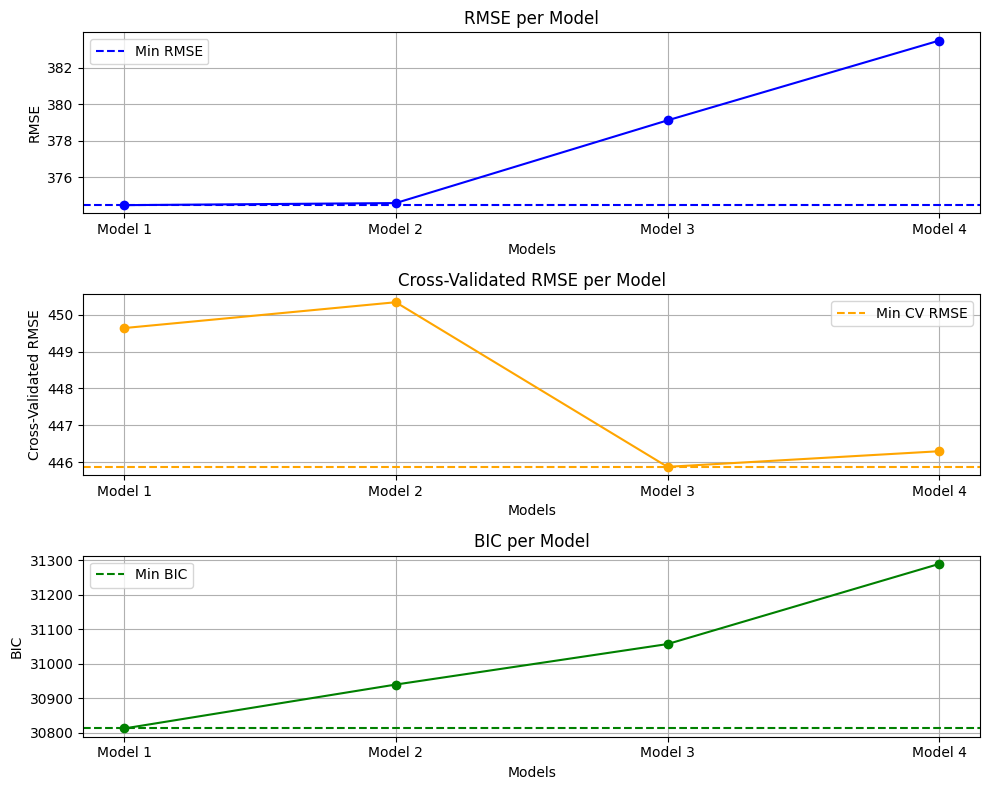

In [11]:

# Visualization of model performance according to class style
models = [result[0] for result in results]
rmses = [result[1] for result in results]
cv_rmses = [result[2] for result in results]
bic_scores = [result[3] for result in results]

plt.figure(figsize=(10, 8))

# Separate plots in a class-style presentation
plt.subplot(3, 1, 1)
plt.plot(models, rmses, marker='o', linestyle='-', color='blue')
plt.axhline(y=min(rmses), color='blue', linestyle='--', label='Min RMSE')
plt.title('RMSE per Model')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(models, cv_rmses, marker='o', linestyle='-', color='orange')
plt.axhline(y=min(cv_rmses), color='orange', linestyle='--', label='Min CV RMSE')
plt.title('Cross-Validated RMSE per Model')
plt.xlabel('Models')
plt.ylabel('Cross-Validated RMSE')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(models, bic_scores, marker='o', linestyle='-', color='green')
plt.axhline(y=min(bic_scores), color='green', linestyle='--', label='Min BIC')
plt.title('BIC per Model')
plt.xlabel('Models')
plt.ylabel('BIC')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


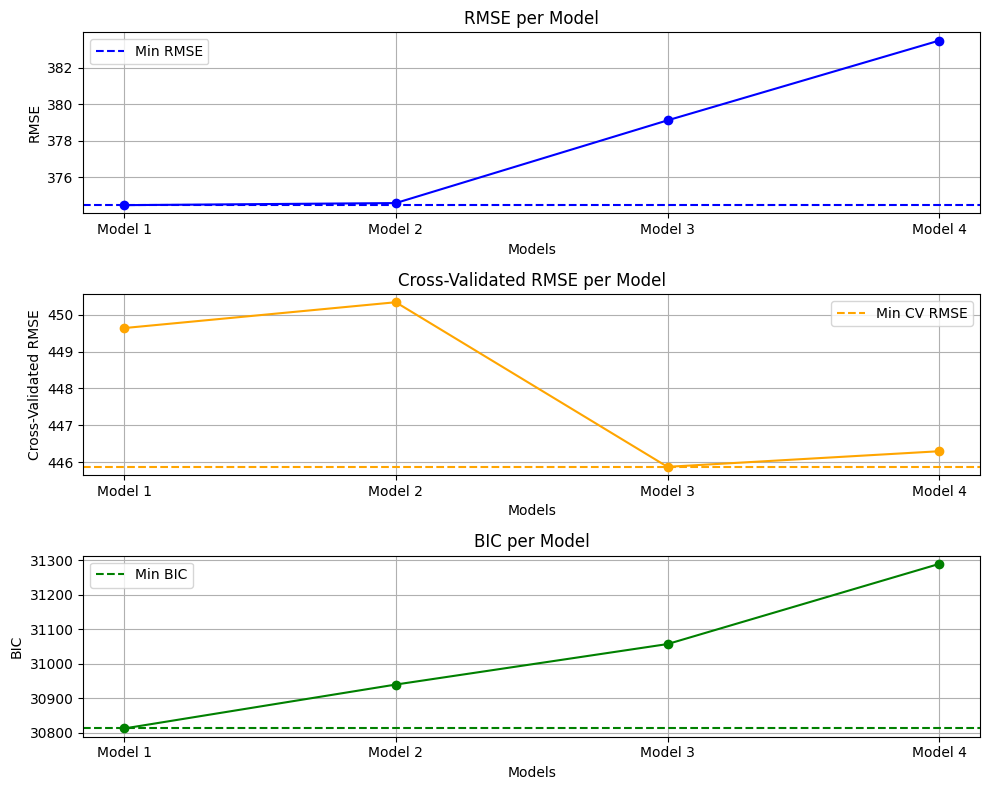

In [13]:
# Visualization of model performance according to class style
models = [result[0] for result in results]
rmses = [result[1] for result in results]
cv_rmses = [result[2] for result in results]
bic_scores = [result[3] for result in results]

plt.figure(figsize=(10, 8))

# Separate plots in a class-style presentation
plt.subplot(3, 1, 1)
plt.plot(models, rmses, marker='o', linestyle='-', color='blue')
plt.axhline(y=min(rmses), color='blue', linestyle='--', label='Min RMSE')
plt.title('RMSE per Model')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(models, cv_rmses, marker='o', linestyle='-', color='orange')
plt.axhline(y=min(cv_rmses), color='orange', linestyle='--', label='Min CV RMSE')
plt.title('Cross-Validated RMSE per Model')
plt.xlabel('Models')
plt.ylabel('Cross-Validated RMSE')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(models, bic_scores, marker='o', linestyle='-', color='green')
plt.axhline(y=min(bic_scores), color='green', linestyle='--', label='Min BIC')
plt.title('BIC per Model')
plt.xlabel('Models')
plt.ylabel('BIC')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


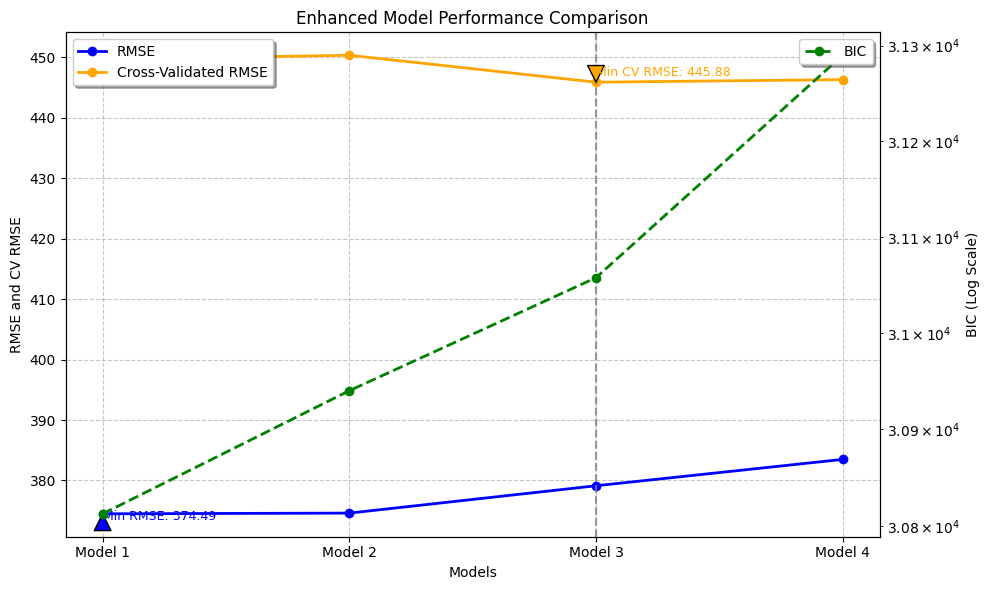

In [14]:

# Visualization of model performance with improved design
models = [result[0] for result in results]
rmses = [result[1] for result in results]
cv_rmses = [result[2] for result in results]
bic_scores = [result[3] for result in results]

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting RMSE and CV RMSE on the primary y-axis with enhanced design
ax1.plot(models, rmses, label='RMSE', marker='o', linestyle='-', color='blue', linewidth=2)
ax1.plot(models, cv_rmses, label='Cross-Validated RMSE', marker='o', linestyle='-', color='orange', linewidth=2)
ax1.set_xlabel('Models')
ax1.set_ylabel('RMSE and CV RMSE')
ax1.set_title('Enhanced Model Performance Comparison')
ax1.legend(loc='upper left', fontsize=10, frameon=True, shadow=True)
ax1.grid(True, linestyle='--', alpha=0.7)

# Adding annotations for minimum values
min_rmse_idx = rmses.index(min(rmses))
min_cv_rmse_idx = cv_rmses.index(min(cv_rmses))
ax1.annotate(f'Min RMSE: {min(rmses):.2f}', xy=(models[min_rmse_idx], rmses[min_rmse_idx]), 
             xytext=(models[min_rmse_idx], rmses[min_rmse_idx] - 1),
             arrowprops=dict(facecolor='blue', shrink=0.05), fontsize=9, color='blue')
ax1.annotate(f'Min CV RMSE: {min(cv_rmses):.2f}', xy=(models[min_cv_rmse_idx], cv_rmses[min_cv_rmse_idx]), 
             xytext=(models[min_cv_rmse_idx], cv_rmses[min_cv_rmse_idx] + 1),
             arrowprops=dict(facecolor='orange', shrink=0.05), fontsize=9, color='orange')

# Plotting BIC on a secondary y-axis with a log scale and refined appearance
ax2 = ax1.twinx()
ax2.plot(models, bic_scores, label='BIC', marker='o', linestyle='--', color='green', linewidth=2)
ax2.set_ylabel('BIC (Log Scale)')
ax2.set_yscale('log')
ax2.legend(loc='upper right', fontsize=10, frameon=True, shadow=True)

# Highlighting the optimal model based on cross-validated RMSE
best_model_idx = cv_rmses.index(min(cv_rmses))
ax1.axvline(x=models[best_model_idx], color='grey', linestyle='--', alpha=0.8)

plt.tight_layout()
plt.show()


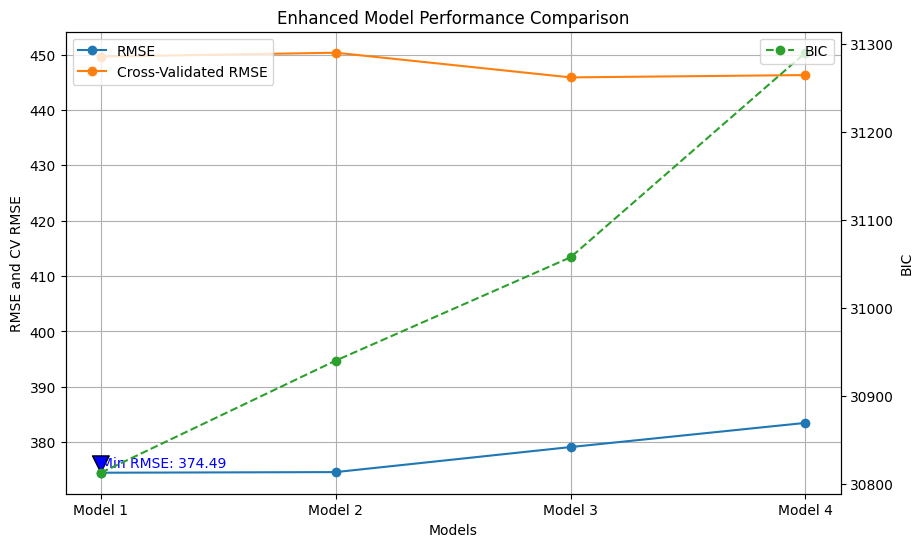

In [15]:
# Visualization of model performance with improved design
models = [result[0] for result in results]
rmses = [result[1] for result in results]
cv_rmses = [result[2] for result in results]
bic_scores = [result[3] for result in results]

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting RMSE and CV RMSE on the primary y-axis with enhanced design
ax1.plot(models, rmses, label='RMSE', marker='o', linestyle='-', color='#1f77b4')
ax1.plot(models, cv_rmses, label='Cross-Validated RMSE', marker='o', linestyle='-', color='#ff7f0e')

ax1.set_xlabel('Models')
ax1.set_ylabel('RMSE and CV RMSE')
ax1.set_title('Enhanced Model Performance Comparison')
ax1.legend(loc='upper left')
ax1.grid(True)

# Plotting BIC on a secondary y-axis without log scale
ax2 = ax1.twinx()
ax2.plot(models, bic_scores, label='BIC', marker='o', linestyle='--', color='#2ca02c')
ax2.set_ylabel('BIC')
ax2.legend(loc='upper right')

# Highlighting the minimum RMSE with an annotation
min_rmse = min(rmses)
min_rmse_model = models[rmses.index(min_rmse)]
ax1.annotate(f'Min RMSE: {min_rmse:.2f}', xy=(min_rmse_model, min_rmse), xytext=(min_rmse_model, min_rmse+1),
             arrowprops=dict(facecolor='blue', shrink=0.05), fontsize=10, color='blue')

plt.show()


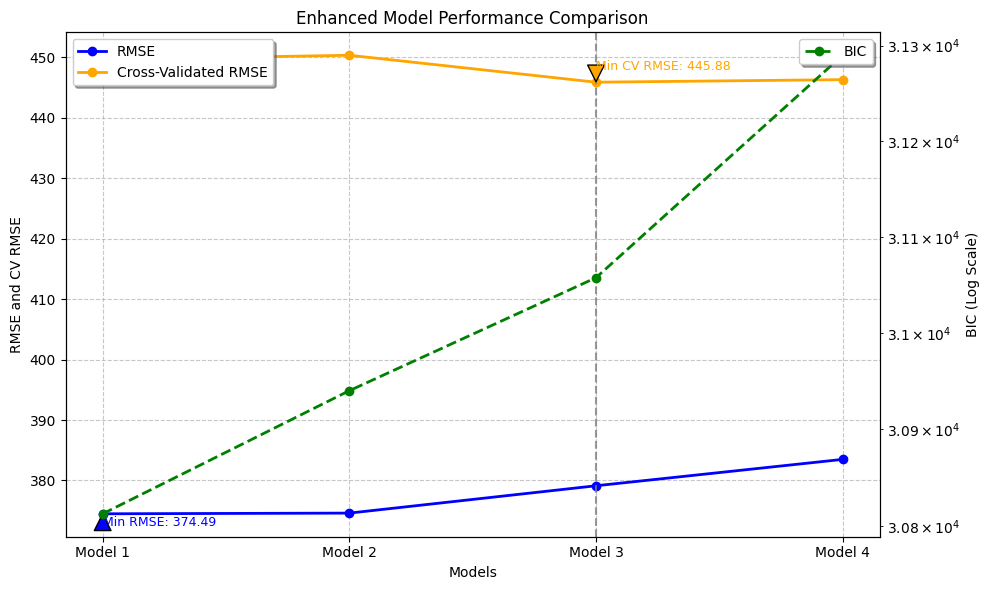

In [20]:

# Visualization of model performance with improved design
models = [result[0] for result in results]
rmses = [result[1] for result in results]
cv_rmses = [result[2] for result in results]
bic_scores = [result[3] for result in results]

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting RMSE and CV RMSE on the primary y-axis with enhanced design
ax1.plot(models, rmses, label='RMSE', marker='o', linestyle='-', color='blue', linewidth=2)
ax1.plot(models, cv_rmses, label='Cross-Validated RMSE', marker='o', linestyle='-', color='orange', linewidth=2)
ax1.set_xlabel('Models')
ax1.set_ylabel('RMSE and CV RMSE')
ax1.set_title('Enhanced Model Performance Comparison')
ax1.legend(loc='upper left', fontsize=10, frameon=True, shadow=True)
ax1.grid(True, linestyle='--', alpha=0.7)

# Adding annotations for minimum values
min_rmse_idx = rmses.index(min(rmses))
min_cv_rmse_idx = cv_rmses.index(min(cv_rmses))
ax1.annotate(f'Min RMSE: {min(rmses):.2f}', xy=(models[min_rmse_idx], rmses[min_rmse_idx]), 
             xytext=(models[min_rmse_idx], rmses[min_rmse_idx] - 2),
             arrowprops=dict(facecolor='blue', shrink=0.05), fontsize=9, color='blue')
ax1.annotate(f'Min CV RMSE: {min(cv_rmses):.2f}', xy=(models[min_cv_rmse_idx], cv_rmses[min_cv_rmse_idx]), 
             xytext=(models[min_cv_rmse_idx], cv_rmses[min_cv_rmse_idx] + 2),
             arrowprops=dict(facecolor='orange', shrink=0.05), fontsize=9, color='orange')

# Plotting BIC on a secondary y-axis with a log scale and refined appearance
ax2 = ax1.twinx()
ax2.plot(models, bic_scores, label='BIC', marker='o', linestyle='--', color='green', linewidth=2)
ax2.set_ylabel('BIC (Log Scale)')
ax2.set_yscale('log')
ax2.legend(loc='upper right', fontsize=10, frameon=True, shadow=True)

# Highlighting the optimal model based on cross-validated RMSE
best_model_idx = cv_rmses.index(min(cv_rmses))
ax1.axvline(x=models[best_model_idx], color='grey', linestyle='--', alpha=0.8)

plt.tight_layout()
plt.show()
